In [39]:
import os

cuda_device = '2'
os.environ["CUDA_VISIBLE_DEVICES"] = cuda_device

import math

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import traceback
from collections import OrderedDict
from tqdm import tqdm, trange

import random

from tensorboardX import SummaryWriter

from scipy import integrate

sns.set_style("white")
torch.cuda.is_available()

from statistics import geometric_mean

torch.set_default_dtype(torch.float64)


# parameters

In [40]:
batch_size = 300
batch_size_LBFGS = 300

epoches = 50000
gamma = 0.99999

num_processes = 20

num_hidden = 4
width = 100

width_R = 5
num_hidden_R = 1

num_divide = 0
num_divide_LBFGS = 0

n_bic_points = 128
n_points_train = n_bic_points
n_inner_points = 128
n_points_test = 256

Adam_proportion = 0.99
coe_without_R = 0.25
coe_without_R_sidecar = 0.25

coe_without_R_new = 0.0
width_R_new = 5
coe_structure_new = 0.0001

tol = 100.0

epoches_noR = 50000
coe_without_R_noR = 0.25
num_hidden_R_noR = 2
width_R_noR = 10
coe_structure_noR = 0.0001

coe_structure = 0.001

x_l = -15.0
x_r = 15.0

t_0 = 0.0
t_T = math.pi / 2.0

def IC(x):
        return 1.0 / torch.cosh(x) * torch.cos(2 * x), -1.0 / torch.cosh(x) * torch.sin(2 * x)

C_1 = 2.0 * np.tanh(15)

def exact_solution(X):
        x = X[:,0]
        t = X[:,1]
        return 1.0 / torch.cosh(x + 2*t) * torch.cos(2*x + 3*t/2), -1.0 / torch.cosh(x + 2*t) * torch.sin(2*x + 3*t/2)

device = torch.device("cpu")

criterion = torch.nn.MSELoss()

param_vector = [100]


In [41]:
def setup_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

class PDE_NN(nn.Module):
    def __init__(
            self,
            width,
            num_hidden,
            input_size = 2,
            hidden_size = None,
            output_size = 2,
            act = nn.Tanh,
        ):
        super(PDE_NN, self).__init__()
        if width is not None:
            hidden_size = [width] * num_hidden
        elif isinstance(hidden_size, list) and len(hidden_size) == num_hidden:
            pass  
        else:
            raise ValueError("Invalid hidden size specification")
        layers = [('input', nn.Linear(input_size, hidden_size[0]))]
        layers.append(('input_activation', act()))
        for i in range(1, num_hidden): 
            layers.append(
                ('hidden_%d' % i, nn.Linear(hidden_size[i-1], hidden_size[i]))
            )
            layers.append(('activation_%d' % i, act()))
        layers.append(('output', nn.Linear(hidden_size[-1], output_size)))
        layerDict = OrderedDict(layers)
        self.layers = nn.Sequential(layerDict)

    def forward(self, X):
        out = self.layers(X) 
        return out

class NN(nn.Module):
    def __init__(self, width, num_hidden):
        super(NN, self).__init__()
        self.PDE = PDE_NN(width, num_hidden)

    def forward(self, X):
        u = self.PDE(X)
        return u


In [43]:
class PDE_NN_sidecar(nn.Module):
    def __init__(
            self,
            width,
            num_hidden,
            input_size = 2,
            hidden_size = None,
            output_size = 2,
            act = nn.Tanh,
        ):
        super(PDE_NN_sidecar, self).__init__()
        if width is not None:
            hidden_size = [width] * num_hidden
        elif isinstance(hidden_size, list) and len(hidden_size) == num_hidden:
            pass  
        else:
            raise ValueError("Invalid hidden size specification")
        layers = [('input', nn.Linear(input_size, hidden_size[0]))]
        layers.append(('input_activation', act()))
        for i in range(1, num_hidden): 
            layers.append(
                ('hidden_%d' % i, nn.Linear(hidden_size[i-1], hidden_size[i]))
            )
            layers.append(('activation_%d' % i, act()))
        layers.append(('output', nn.Linear(hidden_size[-1], output_size)))
        layerDict = OrderedDict(layers)
        self.layers = nn.Sequential(layerDict)

    def forward(self, X):
        out = self.layers(X) 
        return out

class structure_NN_sidecar_real(nn.Module):
    def __init__(
            self,
            width_R,
            num_hidden_R,
            input_size = 1,
            hidden_size = None,
            output_size = 1,
            act = nn.Tanh,
        ):
        super(structure_NN_sidecar_real, self).__init__()
        if width_R is not None:
            hidden_size = [width_R] * num_hidden_R
        elif isinstance(hidden_size, list) and len(hidden_size) == num_hidden_R:
            pass  
        else:
            raise ValueError("Invalid hidden size specification")
        layers = [('input', nn.Linear(input_size, hidden_size[0]))]
        layers.append(('input_activation', act()))
        for i in range(1, num_hidden_R): 
            layers.append(
                ('hidden_%d' % i, nn.Linear(hidden_size[i-1], hidden_size[i]))
            )
            layers.append(('activation_%d' % i, act()))
        layers.append(('output', nn.Linear(hidden_size[-1], output_size, bias = True)))
        layerDict = OrderedDict(layers)
        self.layers = nn.Sequential(layerDict)

    def forward(self, t):
        out = self.layers(t) 
        return out

class NN_sidecar_real(nn.Module):
    def __init__(self, width, num_hidden, width_R, num_hidden_R):
        super(NN_sidecar_real, self).__init__()
        self.PDE = PDE_NN_sidecar(width, num_hidden)
        self.structure = structure_NN_sidecar_real(width_R, num_hidden_R)

    def forward(self, X):
        v = self.PDE(X)
        R = self.structure(X[:,1].reshape(-1, 1))
        return v, R


In [44]:
class bic_Dataset(Dataset):
    def __init__(self, n_points, x_l, x_r, t_0, t_T):
        self.n_points = n_points
        x_initial = torch.linspace(x_l, x_r, n_points * 4 + 1).unsqueeze(1) 
        t_initial = torch.zeros(n_points * 4 + 1, 1)
        t_boundary = torch.linspace(t_0, t_T, n_points).unsqueeze(1)
        x_boundary = torch.full((n_points, 1), x_l)
        self.x = torch.cat([x_initial, x_boundary], dim=0)
        self.t = torch.cat([t_initial, t_boundary], dim=0)
        self.labels = torch.cat([torch.ones(n_points * 4 + 1), torch.full((n_points,), 2)], dim=0).long()

    def __len__(self):
        return 4 * self.n_points

    def __getitem__(self, idx):
        return self.x[idx], self.t[idx], self.labels[idx]


In [45]:
def gradient(func,var,order = 1):
    if order == 1:
        return torch.autograd.grad(inputs = var, 
                                    outputs = func,
                                    grad_outputs=torch.ones_like(func),
                                    create_graph=True,
                                    only_inputs=True)[0]
    else:
        out = gradient(func,var)
        return gradient(out,var,order - 1)

In [46]:
def loss_fn_PINNs(model, X, x_inner, t_inner, x, t, labels, epoch):
        if len(x[labels == 2]) == 0:    if len(x[labels == 2]) == 0:    if len(x[labels == 2]) == 0:
                loss_bc = torch.tensor(0.0, requires_grad=True).to(device)equires_grad=True).to(device)equires_grad=True).to(device)
        else:
                x_bc1 = torch.full_like(x[labels == 2], x_l, requires_grad=True).full_like(x[labels == 2], x_l, requires_grad=True).full_like(x[labels == 2], x_l, requires_grad=True)
                x_bc2 = torch.full_like(x[labels == 2], x_r, requires_grad=True)        x_bc2 = torch.full_like(x[labels == 2], x_r, requires_grad=True)
                t_bc = t[labels == 2]        t_bc = t[labels == 2]
        if len(x[labels == 2]) == 0:
            loss_bc = torch.tensor(0.0, requires_grad=True).to(device)
        else:
            x_bc1 = torch.full_like(x[labels == 2], x_l, requires_grad=True)
            x_bc2 = torch.full_like(x[labels == 2], x_r, requires_grad=True)
            t_bc = t[labels == 2]
            u_pred_bc1 = model(torch.cat([x_bc1, t_bc], dim=1))
            u_pred_bc2 = model(torch.cat([x_bc2, t_bc], dim=1))
            u_pred_bc1_re, u_pred_bc1_im = torch.unbind(u_pred_bc1, dim=1)
            u_pred_bc2_re, u_pred_bc2_im = torch.unbind(u_pred_bc2, dim=1)
            du_dx_bc1_re = gradient(u_pred_bc1_re, x_bc1)[:, 0]
            du_dx_bc1_im = gradient(u_pred_bc1_im, x_bc1)[:, 0]
            du_dx_bc2_re = gradient(u_pred_bc2_re, x_bc2)[:, 0]
            du_dx_bc2_im = gradient(u_pred_bc2_im, x_bc2)[:, 0]
            loss_bc = criterion(u_pred_bc1_re, u_pred_bc2_re) + criterion(u_pred_bc1_im, u_pred_bc2_im) + criterion(du_dx_bc1_re, du_dx_bc2_re) + criterion(du_dx_bc1_im, du_dx_bc2_im)
        if len(x[labels == 1]) == 0:
            loss_ic = torch.tensor(0.0, requires_grad=True).to(device)
        else:
            X_ic = torch.cat([x[labels == 1], t[labels == 1]], dim=1)
            u_pred_ic = model(X_ic)
            u_pred_ic_re, u_pred_ic_im = torch.unbind(u_pred_ic, dim=1)
            u_ic_re, u_ic_im = IC(X_ic[:, 0])
            loss_ic = criterion(u_pred_ic_re, u_ic_re) + criterion(u_pred_ic_im, u_ic_im)
        loss_data = loss_bc + loss_ic
        u_pred = model(X)  
        u_pred_re, u_pred_im = torch.unbind(u_pred, dim=1)
        du_dX_re = gradient(u_pred_re, X)
        du_dX_im = gradient(u_pred_im, X)
        du_dt_re = du_dX_re[:, 1]
        du_dt_im = du_dX_im[:, 1]
        du_dxx_re = gradient(du_dX_re[:, 0], X)[:, 0]
        du_dxx_im = gradient(du_dX_im[:, 0], X)[:, 0]
        u_norm_square = u_pred_re**2 + u_pred_im**2
        loss_re = criterion(-du_dt_im + 0.5 * du_dxx_re + u_norm_square * u_pred_re, torch.zeros(u_pred_re.size()).to(device))
        loss_im = criterion(du_dt_re + 0.5 * du_dxx_im + u_norm_square * u_pred_im, torch.zeros(u_pred_re.size()).to(device))
        loss_pde = loss_re + loss_im
        u_re, u_im = torch.unbind(u_pred, dim=1)
        u_square = u_re ** 2 + u_im ** 2
        u_square_matrix = u_square.reshape(len(x_inner), len(t_inner)).detach().cpu().numpy()
        h = x_inner[1] - x_inner[0]
        temp = integrate.romb(u_square_matrix.T, dx=h.cpu().numpy())
        loss_energy = np.max(np.abs(temp - C_1))
        exact_re, exact_im = exact_solution(X)
        loss_exact = criterion(u_pred_re, exact_re) + criterion(u_pred_im, exact_im)
        loss = loss_pde + loss_data
        return loss, loss_pde, loss_data, loss_energy, loss_exact


In [47]:
def loss_fn_real(model, X, x_inner, t_inner, x, t, labels, epoch):
    if len(x[labels == 2]) == 0:
        loss_bc = torch.tensor(0.0, requires_grad=True).to(device)
    else:
        x_bc1 = torch.full_like(x[labels == 2], x_l, requires_grad=True)
        x_bc2 = torch.full_like(x[labels == 2], x_r, requires_grad=True)
        t_bc = t[labels == 2]
        v_pred_bc1, R_bc1 = model(torch.cat([x_bc1, t_bc], dim=1))
        v_pred_bc2, R_bc2 = model(torch.cat([x_bc2, t_bc], dim=1))
        u_pred_bc1_re, u_pred_bc1_im = torch.unbind(v_pred_bc1 * R_bc1, dim=1)
        u_pred_bc2_re, u_pred_bc2_im = torch.unbind(v_pred_bc2 * R_bc2, dim=1)
        du_dx_bc1_re = gradient(u_pred_bc1_re, x_bc1)[:, 0]
        du_dx_bc1_im = gradient(u_pred_bc1_im, x_bc1)[:, 0]
        du_dx_bc2_re = gradient(u_pred_bc2_re, x_bc2)[:, 0]
        du_dx_bc2_im = gradient(u_pred_bc2_im, x_bc2)[:, 0]
        loss_bc = criterion(u_pred_bc1_re, u_pred_bc2_re) + criterion(u_pred_bc1_im, u_pred_bc2_im) + criterion(du_dx_bc1_re, du_dx_bc2_re) + criterion(du_dx_bc1_im, du_dx_bc2_im)
    if len(x[labels == 1]) == 0:
        loss_ic = torch.tensor(0.0, requires_grad=True).to(device)
    else:
        X_ic = torch.cat([x[labels == 1], t[labels == 1]], dim=1)
        u_pred_ic, R_ic = model(X_ic)
        u_pred_ic_re, u_pred_ic_im = torch.unbind(u_pred_ic * R_ic, dim=1)
        u_ic_re, u_ic_im = IC(X_ic[:, 0])
        loss_ic = criterion(u_pred_ic_re, u_ic_re) + criterion(u_pred_ic_im, u_ic_im)
    loss_data = loss_bc + loss_ic
    v_pred, R = model(X)
    u_pred_re, u_pred_im = torch.unbind(v_pred * R, dim=1)
    du_dX_re = gradient(u_pred_re, X)
    du_dX_im = gradient(u_pred_im, X)
    du_dt_re = du_dX_re[:, 1]
    du_dt_im = du_dX_im[:, 1]
    du_dxx_re = gradient(du_dX_re[:, 0], X)[:, 0]
    du_dxx_im = gradient(du_dX_im[:, 0], X)[:, 0]
    u_norm_square = u_pred_re**2 + u_pred_im**2
    loss_re = criterion(-du_dt_im + 0.5 * du_dxx_re + u_norm_square * u_pred_re, torch.zeros(u_pred_re.size()).to(device))
    loss_im = criterion(du_dt_re + 0.5 * du_dxx_im + u_norm_square * u_pred_im, torch.zeros(u_pred_re.size()).to(device))
    loss_pde = loss_re + loss_im
    loss_structure = 0.0
    u_square = u_pred_re ** 2 + u_pred_im ** 2
    u_square_matrix = u_square.reshape(len(x_inner), len(t_inner)).detach().cpu().numpy()
    h = x_inner[1] - x_inner[0]
    temp = integrate.romb(u_square_matrix.T, dx=h.cpu().numpy())
    loss_energy_vector = np.abs(temp - C_1)
    loss_energy = np.max(loss_energy_vector)
    u_exact_re, u_exact_im = exact_solution(X)
    loss_exact = criterion(u_pred_re, u_exact_re) + criterion(u_pred_im, u_exact_im)
    loss = loss_pde + loss_data + coe_structure * loss_structure
    return loss, loss_pde, loss_data, loss_energy, loss_exact, loss_structure


In [48]:
x_test = torch.linspace(x_l, x_r, n_points_test * 4 + 1)
t_test = torch.linspace(t_0, t_T, n_points_test)

X_test = torch.stack(torch.meshgrid(x_test, t_test, indexing='ij')).reshape(2, -1).T
X_test = X_test.to(device)
X_test.requires_grad = True

x_ic_test = x_test.unsqueeze(1)
t_ic_test = torch.zeros(n_points_test * 4 + 1, 1)

t_bc_test = t_test.unsqueeze(1)
x_bc_test = torch.full((n_points_test, 1), x_l)

x = torch.cat([x_ic_test, x_bc_test], dim=0).to(device)
t = torch.cat([t_ic_test, t_bc_test], dim=0).to(device)
labels = torch.cat([torch.ones(n_points_test * 4 + 1), torch.full((n_points_test,), 2)], dim=0).long().to(device)


# load

In [49]:
learning_rate = 0.00001

coe_without_R = 1.0

width_R = 5

num_hidden_R = 2

epoches = 120000

batch_size = 2046

i = 0

result_matrix_PINNs = np.zeros((len(param_vector), num_processes, 5))

for width in param_vector:

    if num_divide_LBFGS != 0:
        width_R = int(width/num_divide)

    for j in range(num_processes):

        model = NN(width + width_R, num_hidden).to(device)

        model.load_state_dict(torch.load(f"/home/22040517r/sidecar/Sidecar/codes/NLS/parallel/moving/PINNs_float64/trained_model/NLS-Original-bs{batch_size}-epoches{epoches}-width{width + width_R}-n_bic{n_bic_points}-n_inner{n_inner_points}-gamma{gamma}-{j}.pth", map_location=device))

        model.eval()

        loss_vector = loss_fn_PINNs(model, X_test, x_test, t_test, x, t, labels, epoches)

        result_matrix_PINNs[i, j, :] = torch.tensor(loss_vector)

        del model, loss_vector
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

    i += 1


In [50]:
results = result_matrix_PINNs

print(results)

first_component = results[..., 1] + results[..., 2]

print(first_component)

max_errors_PINNs = np.min(first_component, axis=1)
max_errors_positions = np.argmin(first_component, axis=1)

model = NN(width + width_R, num_hidden).to(device)

model.load_state_dict(torch.load(f"/home/22040517r/sidecar/Sidecar/codes/NLS/parallel/moving/PINNs_float64/trained_model/NLS-Original-bs{batch_size}-epoches{epoches}-width{width + width_R}-n_bic{n_bic_points}-n_inner{n_inner_points}-gamma{gamma}-{max_errors_positions.item()}.pth", map_location=device))

u_pred = model(X_test)

u_pred_re, u_pred_im = torch.unbind(u_pred, dim=1)

u_pred_square = u_pred_re ** 2 + u_pred_im ** 2

u_pred_matrix = u_pred_square.reshape(len(x_test), len(t_test)).detach().cpu().numpy()

u_pred_re_matrix = u_pred_re.reshape(len(x_test), len(t_test)).detach().cpu().numpy()
u_pred_im_matrix = u_pred_im.reshape(len(x_test), len(t_test)).detach().cpu().numpy()


In [51]:
epoches = 20000
gamma = 0.9999
learning_rate = 0.00001

coe_without_R = 1.0

width_R = 10

num_hidden_R = 2

batch_size = 2046

i = 0

result_matrix_sidecar_LBFGS_real = np.zeros((len(param_vector), num_processes, 6))

for width in param_vector:

    if num_divide_LBFGS != 0:
        width_R = int(width/num_divide)

    for j in range(num_processes):

        model = NN_sidecar_real(width, num_hidden, width_R, num_hidden_R).to(device)

        model.load_state_dict(torch.load(f"/home/22040517r/sidecar/Sidecar/codes/NLS/parallel/moving/sidecar_after_real/trained_model/NLS-after-15-romb-lr{learning_rate}-bs{batch_size}-epoches{epoches}-width{width}-depth{num_hidden}-widthR{width_R}-depthR{num_hidden_R}-n_bic{n_bic_points}-n_inner{n_inner_points}-coeR{coe_without_R}-gamma{gamma}-{j}.pth", map_location=device))

        model.eval()

        loss_vector = loss_fn_real(model, X_test, x_test, t_test, x, t, labels, epoches)

        result_matrix_sidecar_LBFGS_real[i, j, :] = torch.tensor(loss_vector)

        del model, loss_vector
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

    i += 1


In [52]:
results = result_matrix_sidecar_LBFGS_real

print(results)

first_component = results[..., 1] + results[..., 2]

print(first_component)

max_errors_sidecar_LBFGS_real = np.min(first_component, axis=1)
max_errors_positions = np.argmin(first_component, axis=1)

model = NN_sidecar_real(width, num_hidden, width_R, num_hidden_R).to(device)

model.load_state_dict(torch.load(f"/home/22040517r/sidecar/Sidecar/codes/NLS/parallel/moving/sidecar_after_real/trained_model/NLS-after-romb-lr{learning_rate}-bs{batch_size}-epoches{epoches}-width{width}-depth{num_hidden}-widthR{width_R}-depthR{num_hidden_R}-n_bic{n_bic_points}-n_inner{n_inner_points}-coeR{coe_without_R}-gamma{gamma}-{max_errors_positions.item()}.pth", map_location=device))

v_pred, R = model(X_test)

u_pred_sidecar = v_pred * R

u_pred_sidecar_re, u_pred_sidecar_im = torch.unbind(u_pred, dim=1)

u_pred_sidecar_square = u_pred_re ** 2 + u_pred_im ** 2

u_pred_square_sidecar_matrix = u_pred_square.reshape(len(x_test), len(t_test)).detach().cpu().numpy()

u_pred_re_sidecar_matrix = u_pred_sidecar_re.reshape(len(x_test), len(t_test)).detach().cpu().numpy()
u_pred_im_sidecar_matrix = u_pred_sidecar_im.reshape(len(x_test), len(t_test)).detach().cpu().numpy()


# plot

In [53]:
from statistics import geometric_mean

from matplotlib.ticker import FixedLocator, NullFormatter, LogLocator, FixedFormatter, FuncFormatter

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'cm'

x = np.array(param_vector)

index = param_vector 



Plotting for time index: 163, i: 0
Plotting for time index: 163, i: 1
Plotting for time index: 163, i: 2


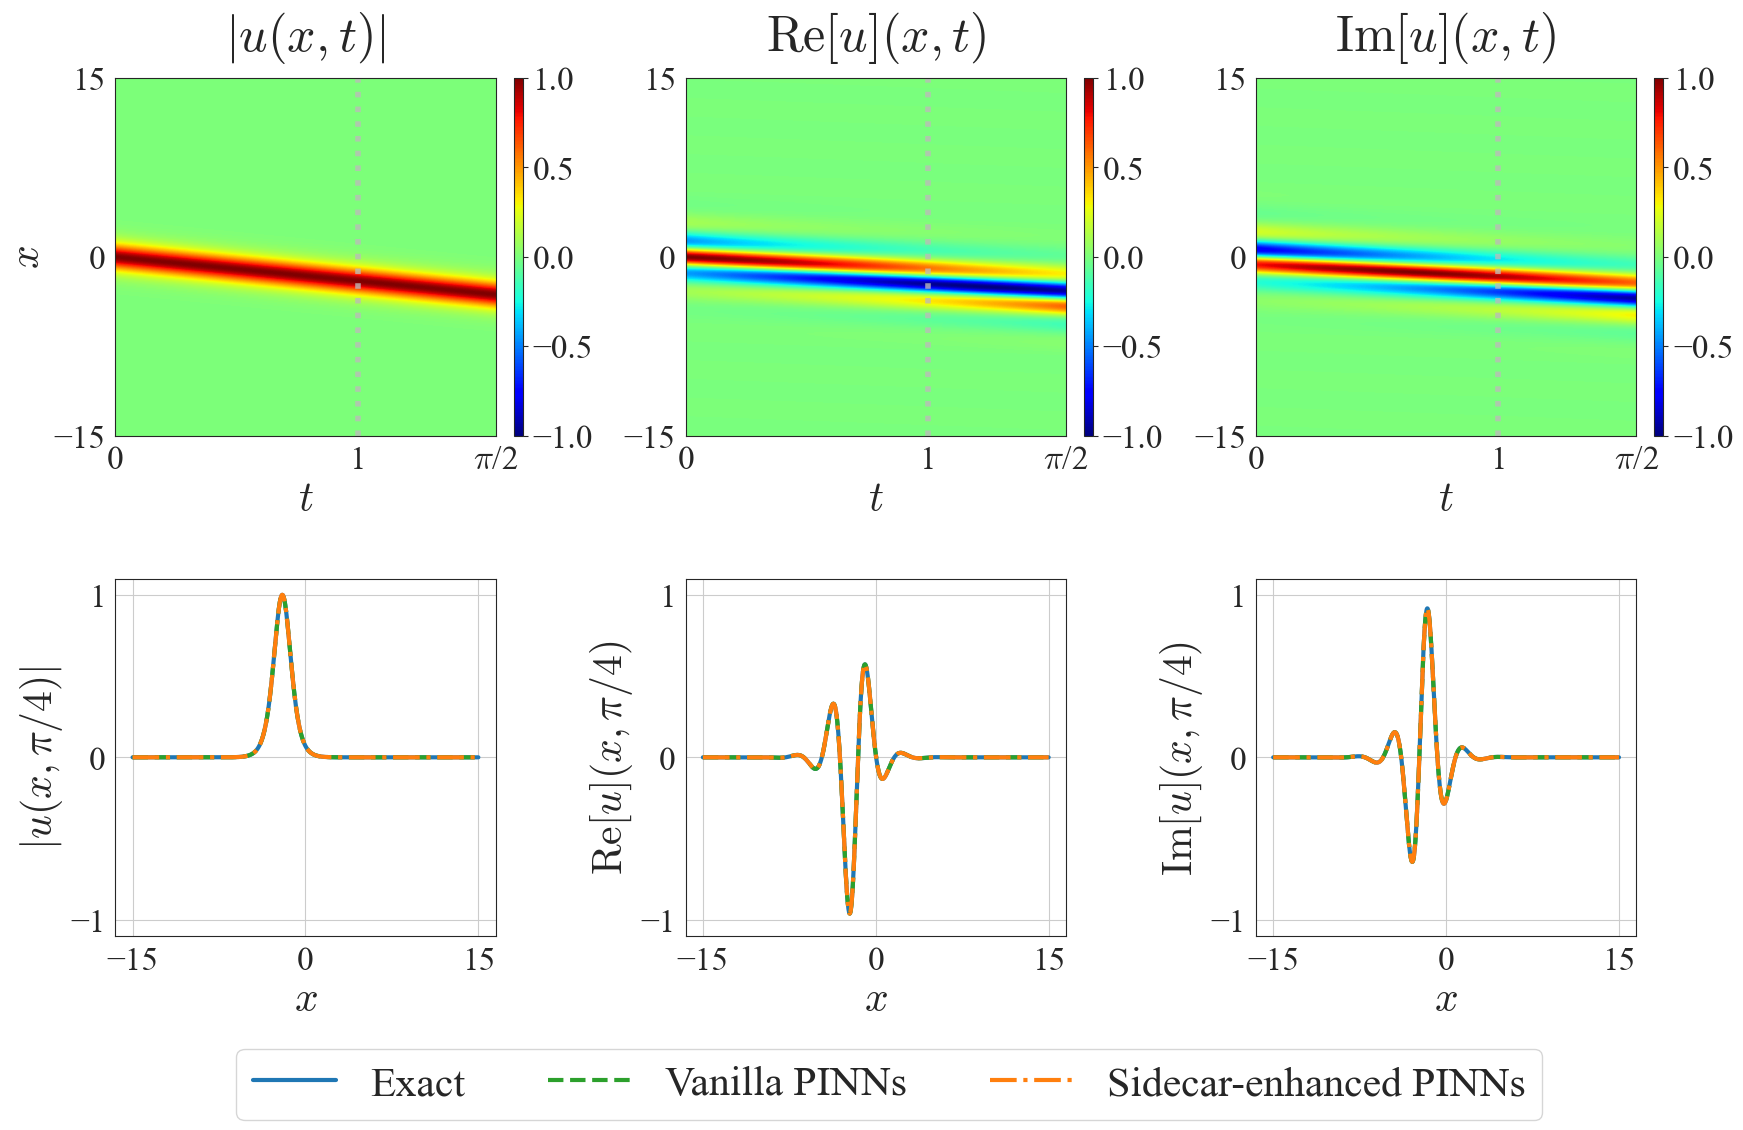

In [120]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

FONT_SIZE = {
    'title': 36,
    'label': 30,
    'tick': 24,
    'legend': 30,
    'colorbar': 24
}

plt.rcParams['font.size'] = FONT_SIZE['tick']
plt.rcParams['axes.titlesize'] = FONT_SIZE['title']
plt.rcParams['axes.labelsize'] = FONT_SIZE['label']
plt.rcParams['xtick.labelsize'] = FONT_SIZE['tick']
plt.rcParams['ytick.labelsize'] = FONT_SIZE['tick']
plt.rcParams['legend.fontsize'] = FONT_SIZE['legend']

fig = plt.figure(figsize=(18, 9.75))

main_gs = GridSpec(2, 3, figure=fig, wspace=0.4, hspace=0.4, 
                   left=0.07, right=0.93, top=0.96, bottom=0.08)

cbar_width = 0.005
cbar_pad = 0.01

slice_time = 1

def set_ax_font(ax, title=None, xlabel=None, ylabel=None):
    if title:
        ax.set_title(title, fontsize=FONT_SIZE['title'], pad=20)
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=FONT_SIZE['label'])
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=FONT_SIZE['label'])
    ax.tick_params(axis='both', labelsize=FONT_SIZE['tick'])

axes_row1 = []
cbars = []

for i in range(3):
    ax_temp = fig.add_subplot(main_gs[0, i])
    pos = ax_temp.get_position()
    ax_temp.remove()
    main_width = pos.width - cbar_width - cbar_pad
    ax = fig.add_axes([pos.x0, pos.y0, main_width, pos.height])
    axes_row1.append(ax)
    cax = fig.add_axes([pos.x0 + main_width + cbar_pad, pos.y0, cbar_width, pos.height])
    if i == 0:
        im = ax.imshow(u_exact_matrix, extent=[0, 1.57, -15, 15], origin='lower',
                      aspect='auto', cmap='jet', vmin=data_min, vmax=data_max)
        set_ax_font(ax, title=r"$|u(x,t)|$", xlabel="$t$", ylabel="$x$")
    elif i == 1:
        im = ax.imshow(u_exact_re_matrix, extent=[0, 1.57, -15, 15], origin='lower',
                      aspect='auto', cmap='jet', vmin=data_min, vmax=data_max)
        set_ax_font(ax, title=r"$\text{Re}[u](x,t)$", xlabel="$t$")
    else:
        im = ax.imshow(u_exact_im_matrix, extent=[0, 1.57, -15, 15], origin='lower',
                      aspect='auto', cmap='jet', vmin=data_min, vmax=data_max)
        set_ax_font(ax, title=r"$\operatorname{Im}[u](x,t)$", xlabel="$t$")
    ax.set_yticks([-15, 0, 15])
    ax.set_xticks([0, 1, 1.57])
    ax.set_xticklabels(['0', '1', '$\pi$/2'])
    ax.axvline(x=slice_time, color='#BBBCB9', linestyle=':', linewidth=4, alpha=0.8)
    cbar = fig.colorbar(im, cax=cax, orientation="vertical")
    cbar.ax.tick_params(labelsize=FONT_SIZE['colorbar'])
    cbars.append(cbar)

axes_row2 = []

for i in range(3):
    pos_ref = axes_row1[i].get_position()
    ax_temp = fig.add_subplot(main_gs[1, i])
    pos_temp = ax_temp.get_position()
    ax_temp.remove()
    ax = fig.add_axes([pos_ref.x0, pos_temp.y0, pos_ref.width, pos_temp.height])
    axes_row2.append(ax)
    time = int(np.shape(u_exact_matrix)[1]*2/np.pi)+1
    print(f"Plotting for time index: {time}, i: {i}")
    linewidth = 3
    if i == 0:
        ax.plot(x_vals, u_exact_matrix[:, time], linewidth=linewidth, label='Exact')
        ax.plot(x_vals, u_pred_matrix[:, time], '--', linewidth=linewidth, color='tab:green', label='Vanilla PINNs')
        ax.plot(x_vals, u_pred_square_sidecar_matrix[:, time], '-.', linewidth=linewidth, color='tab:orange', label='Sidecar-enhanced PINNs')
        set_ax_font(ax, xlabel="$x$", ylabel=r"$|u(x,\pi/4)|$")
    elif i == 1:
        ax.plot(x_vals, u_exact_re_matrix[:, time], linewidth=linewidth, label='Exact')
        ax.plot(x_vals, u_pred_re_matrix[:, time], '--', linewidth=linewidth, color='tab:green')
        ax.plot(x_vals, u_pred_re_sidecar_matrix[:, time], '-.', linewidth=linewidth, color='tab:orange')
        set_ax_font(ax, xlabel="$x$", ylabel=r"$\operatorname{Re}[u](x,\pi/4)$")
    else:
        ax.plot(x_vals, u_exact_im_matrix[:, time], linewidth=linewidth, label='Exact')
        ax.plot(x_vals, u_pred_im_matrix[:, time], '--', linewidth=linewidth, color='tab:green')
        ax.plot(x_vals, u_pred_im_sidecar_matrix[:, time], '-.', linewidth=linewidth, color='tab:orange')
        set_ax_font(ax, xlabel="$x$", ylabel=r"$\operatorname{Im}[u](x,\pi/4)$")
    ax.set_ylim(-1.1, 1.1)
    ax.set_xticks([-15, 0, 15])
    ax.set_yticks([-1, 0, 1])
    ax.grid()

handles, labels = axes_row2[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=FONT_SIZE['legend'], bbox_to_anchor=(0.5, -0.13))

plt.savefig("/home/22040517r/sidecar/Sidecar/codes/NLS/parallel/moving/NLS_solutions_2x3.pdf", bbox_inches='tight')
plt.show()


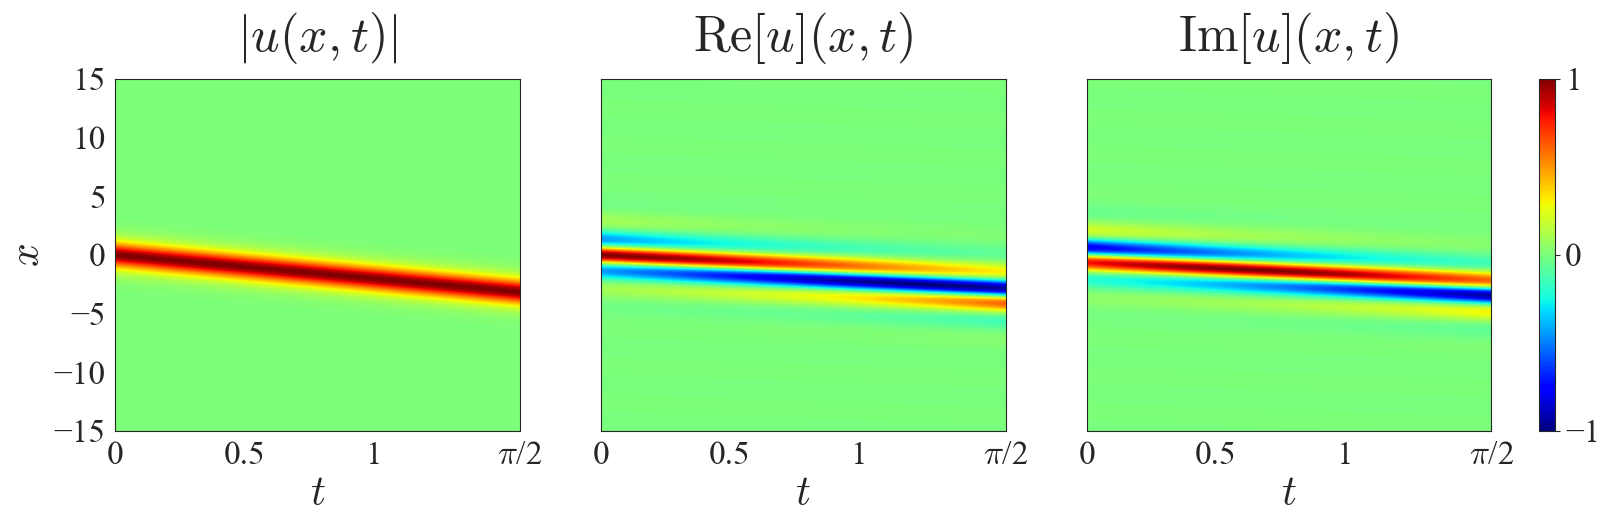

In [203]:
fig1 = plt.figure(figsize=(16, 4))
main_gs1 = GridSpec(1, 3, figure=fig1, wspace=0.2, left=0.07, right=0.93, top=0.96, bottom=0.08)

cbar_width = 0.01
cbar_ax = fig1.add_axes([0.96, 0.08, cbar_width, 0.88])

axes_row1 = []

for i in range(3):
    ax_temp = fig1.add_subplot(main_gs1[0, i])
    pos = ax_temp.get_position()
    ax_temp.remove()
    
    ax = fig1.add_axes([pos.x0, pos.y0, pos.width, pos.height])
    axes_row1.append(ax)
    
    if i == 0:
        im = ax.imshow(u_exact_matrix, extent=[0, 1.57, -15, 15], origin='lower',
                      aspect='auto', cmap='jet', vmin=data_min, vmax=data_max)
        set_ax_font(ax, title=r"$|u(x,t)|$", xlabel="$t$", ylabel="$x$")
        ax.set_yticks([-15, -10, -5, 0, 5, 10, 15])
    elif i == 1:
        im = ax.imshow(u_exact_re_matrix, extent=[0, 1.57, -15, 15], origin='lower',
                      aspect='auto', cmap='jet', vmin=data_min, vmax=data_max)
        set_ax_font(ax, title=r"$\text{Re}[u](x,t)$", xlabel="$t$")
        ax.set_yticks([])
    else:
        im = ax.imshow(u_exact_im_matrix, extent=[0, 1.57, -15, 15], origin='lower',
                      aspect='auto', cmap='jet', vmin=data_min, vmax=data_max)
        set_ax_font(ax, title=r"$\operatorname{Im}[u](x,t)$", xlabel="$t$")
        ax.set_yticks([])

    ax.set_xticks([0, 0.5, 1, 1.57])
    ax.set_xticklabels(['0', '0.5', '1', '$\pi$/2'])

colorbar_ticks = np.linspace(data_min, data_max, 3)
cbar = fig1.colorbar(im, cax=cbar_ax, orientation="vertical")
cbar.ax.tick_params(labelsize=FONT_SIZE['colorbar'])
cbar.set_ticks(colorbar_ticks)

fig1.savefig("/home/22040517r/sidecar/Sidecar/codes/NLS/parallel/moving/NLS_heatmaps.pdf", bbox_inches='tight')
